<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj

Cloning into 'vgg16obj'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 189 (delta 98), reused 93 (delta 40), pack-reused 0
Receiving objects: 100% (189/189), 2.29 MiB | 1.82 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [5]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class

replace data_6class/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc

(1554, 224, 224, 3) (150, 224, 224, 3) (162, 224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

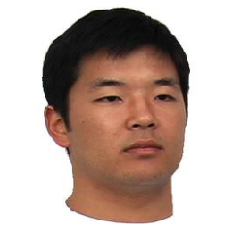

In [8]:
def convertimgs(path,data) :
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            data.append(im) 
    return data


train_it = []
train_it = convertimgs('/content/data_6class/train/faces/Male',train_it)
train_it = convertimgs('/content/data_6class/train/faces/Female/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Manmade/',train_it)
train_it = convertimgs('/content/data_6class/train/scenes/Natural/',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Powered',train_it)
train_it = convertimgs('/content/data_6class/train/objects/Nonpowered',train_it)
train_it = np.array(train_it)

val_it = []
val_it = convertimgs('/content/data_6class/val/faces/Male/',val_it)
val_it = convertimgs('/content/data_6class/val/faces/Female/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Manmade/',val_it)
val_it = convertimgs('/content/data_6class/val/scenes/Natural/',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Powered',val_it)
val_it = convertimgs('/content/data_6class/val/objects/Nonpowered',val_it)
val_it = np.array(val_it)

test_it = []
test_it = convertimgs('/content/data_6class/test/faces/Male/',test_it)
test_it = convertimgs('/content/data_6class/test/faces/Female/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Manmade/',test_it)
test_it = convertimgs('/content/data_6class/test/scenes/Natural/',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Powered',test_it)
test_it = convertimgs('/content/data_6class/test/objects/Nonowered',test_it)
test_it = np.array(test_it)

print(train_it.shape,val_it.shape,test_it.shape)

plt.imshow(train_it[0])
plt.axis('off')

In [9]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
#plot_model(model,show_shapes=True,expand_nested=True)

58892288/58889256 [==============================] - 5s 0us/step


In [10]:
start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_val = model.predict(val_it) 
print(f'Val Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')

     
#np.save('features_train' , features_train)
#np.save('features_val', features_val)
#np.save('features_test', features_test)

Train Time: 15.60859751701355
Val Time: 1.873119831085205
Test Time: 1.2038042545318604


In [11]:
epochs = 30

#train_data = np.load('features_train.npy')
train_data = features_train
train_labels = to_categorical([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279,6)
train_labels1 = to_categorical([0] * 250 + [1]*250 + [0] * 250 + [1] * 250 + [0] * 275 + [1] * 279,2)
train_labels2 = to_categorical([0] * 250 + [0]*250 + [1] * 250 + [1] * 250 + [2] * 275 + [2] * 279,3)



#val_data = np.load('features_val.npy')
val_data = features_val
val_labels = to_categorical([0] * 25 + [1]*25 + [2] * 25 + [3] * 25 + [4] * 25 + [5] * 25,6)
val_labels1 = to_categorical([0] * 25 + [1]*25 + [0] * 25 + [1] * 25 + [0] * 25 + [1] * 25,2)
val_labels2 = to_categorical([0] * 25 + [0]*25 + [1] * 25 + [1] * 25 + [2] * 25 + [2] * 25,3)


#test_data = np.load('features_test.npy')
test_data = features_test
#test_labels = [0] * 50 + [1] * 50 + [2] * 50
#test_labels = [0] * 61 + [1] * 40 + [2] * 61
test_labels = to_categorical([0] * 31 + [1]*30 + [2] * 19 + [3] * 21 + [4] * 31 + [5] * 30,6)
test_labels1 = to_categorical([0] * 31 + [1]*30 + [0] * 19 + [1] * 21 + [0] * 31 + [1] * 30,2)
test_labels2 = to_categorical([0] * 31 + [0]*30 + [1] * 19 + [1] * 21 + [2] * 31 + [2] * 30,3)
#test_labels = to_categorical(test_labels, 3)


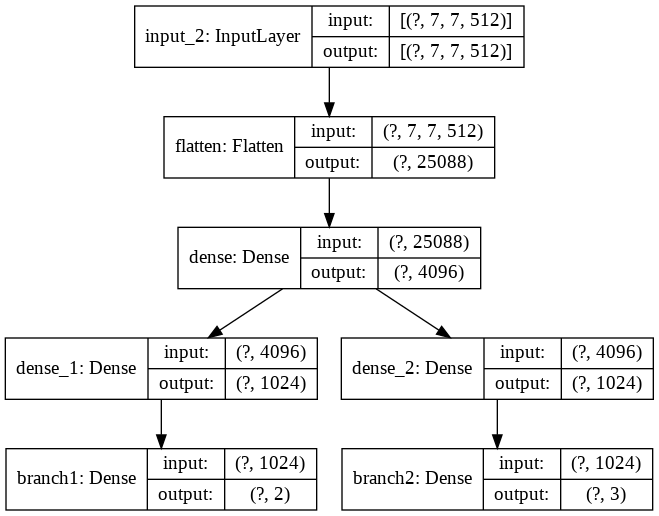

In [9]:
#@title Automated Branched Model Generation
from vgg16obj.tools import objnet

model = objnet.modelarch().build_full_model([7,7,512],
                                            stem_len = [4096],
                                            b1_len = [1024],
                                            b2_len = [1024])
plot_model(model,show_shapes=True,expand_nested=True)

In [12]:

'''losses = {'branch1': 'binary_crossentropy',
          'branch2': 'categorical_crossentropy'}
'''
losses = 'categorical_crossentropy'

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(6, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
top_model.summary()


top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          validation_data=(val_data, val_labels),
          verbose = 1, callbacks = [es])

#model.save_weights('top_weights',overwrite = True)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
predictions (Dense)          (None, 6)                 24582     
Total params: 102,789,126
Trainable params: 102,789,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
25/25 [==============================] - 1s 41ms/step - loss: 1.0608 - accuracy: 0.6203 - val_loss: 0.6173 - val_accuracy: 0.7800
Epoch 2/30
25/25 [==============================] - 1s 36ms/step - loss: 0.3869 - accuracy: 0.8610 - val_loss: 0.4577 - val_accuracy: 0.7867
Epoch 3/30
25/25 [==============================] - 1s 37ms/step - loss: 0.2571 - accuracy

In [13]:
out = top_model.evaluate(test_data, test_labels)
print(out)
#print('rounded test labels',pred)

6/6 [==============================] - 0s 6ms/step - loss: 0.3777 - accuracy: 0.8457
[0.37774521112442017, 0.845678985118866]


In [14]:
#@title Branch loss plotting code
'''
lossNames = ["loss", "branch1_loss", "branch2_loss"]
plt.style.use("ggplot")
e = len(history.history['loss'])
(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(np.arange(0, e), history.history[l], label=l)
	ax[i].plot(np.arange(0, e), history.history["val_" + l],
		label="validation_" + l)
	ax[i].legend()
'''

'\nlossNames = ["loss", "branch1_loss", "branch2_loss"]\nplt.style.use("ggplot")\ne = len(history.history[\'loss\'])\n(fig, ax) = plt.subplots(1, 3, figsize=(20, 5))\n# loop over the loss names\nfor (i, l) in enumerate(lossNames):\n\t# plot the loss for both the training and validation data\n\ttitle = "Loss for {}".format(l) if l != "loss" else "Total loss"\n\tax[i].set_title(title)\n\tax[i].set_xlabel("Epoch #")\n\tax[i].set_ylabel("Loss")\n\tax[i].plot(np.arange(0, e), history.history[l], label=l)\n\tax[i].plot(np.arange(0, e), history.history["val_" + l],\n\t\tlabel="validation_" + l)\n\tax[i].legend()\n'

Normalized confusion matrix


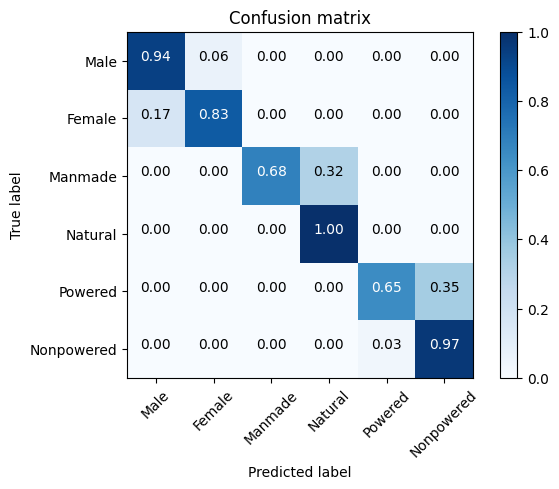

In [15]:
classes = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
#classes = ['Male/ Manmade/ Pwrd','Female/ Natural/ Nonpwrd']
#classes = ['Face', 'Scene','Tool']
plt.style.use('default')
pred = top_model.predict(test_data)
from vgg16obj.tools import plot_tools as pt
#pt.plot_metrics(history)

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(pred).idxmax(axis=1)
cm = confusion_matrix(categorical_test_labels, categorical_preds)

pt.plot_confusion_matrix(cm,classes,normalize = True)

Feature Map Extraction/Test Run

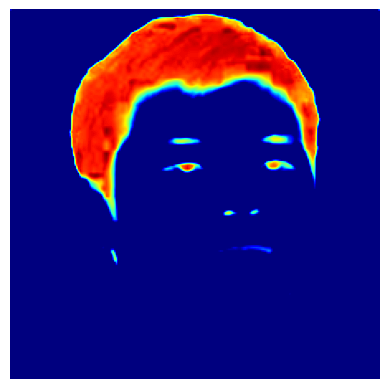

In [16]:
from keras import Model
img_tensor = train_it[0].reshape([1,224,224,3])

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])

layer_outputs = [layer.output for layer in model.layers if 'conv1' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='jet')
plt.axis('off')
plt.show()


Calculating mean activity of feature maps in each layer

In [15]:
'''layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


start = time.time()
tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
print(f'Elapsed: {time.time() - start}s')

with open('tuning_values', 'wb') as fp:
    pickle.dump(tun_activ, fp)
    '''


"layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]\nlayer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]\nactivation_model = Model(inputs=model.input, outputs=layer_outputs)\n\n\nstart = time.time()\ntun_activ = tc.calc_tun(train_it,activation_model,layer_names)\nprint(f'Elapsed: {time.time() - start}s')\n\nwith open('tuning_values', 'wb') as fp:\n    pickle.dump(tun_activ, fp)\n    "

# Tuning values

In [17]:
with open ('/content/drive/My Drive/obj/outfile', 'rb') as fp:
    tun_activ = pickle.load(fp)


### Calculation of tuning values for each map

In [18]:
ncats = 6
labels = np.array([0] * 250 + [1]*250 + [2] * 250 + [3] * 250 + [4] * 275 + [5] * 279)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


###Calculation of tuning quality for each map

In [19]:
tun_quality = tc.calc_tun_quality(fc)

### Plot tuning quality boxplots

(0.0, 100.0)

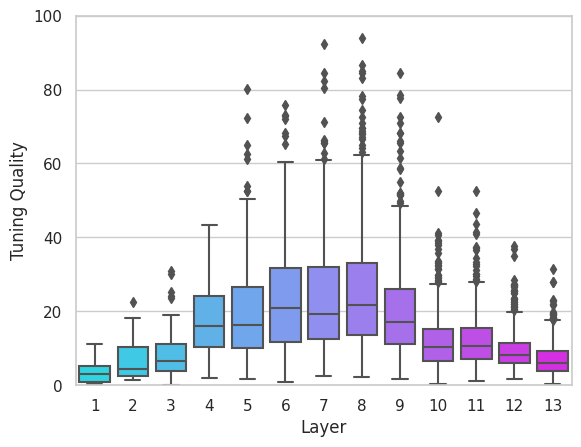

In [20]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,100])

### Plot tuning curves


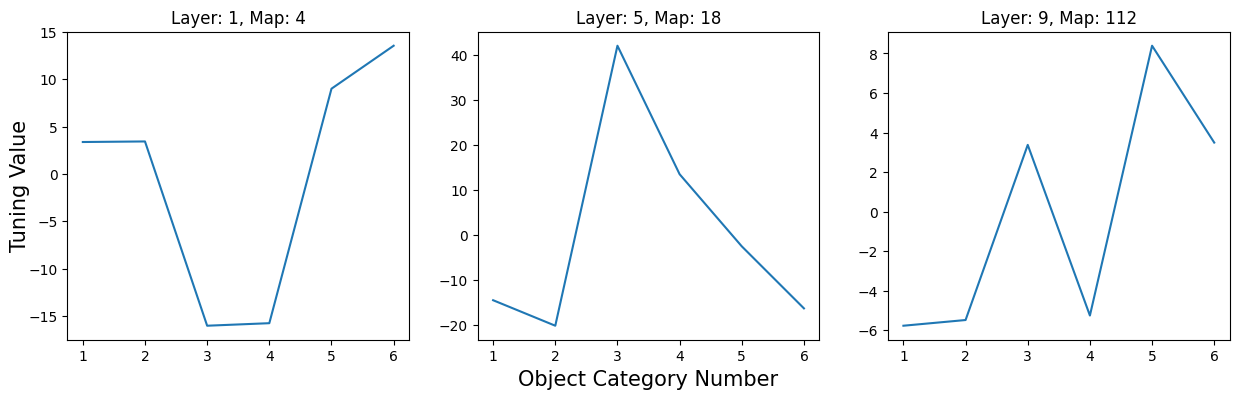

In [20]:
layers = [1,5,9]
maps = [4,18,112]
fig = pt.plot_tun_curves(fc,layers,maps)

#Gradient Values

In [ ]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [244,244,3])
model.summary()

top_model.summary()

In [ ]:
import tensorflow as tf


layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


start = time.time()
for i in range(ncats):
  idx = list(np.where(labels == i))
  cat_grads[i] = gc.calc_avg_gradcam(train_it[idx],model,top_model)
print(f'Elapsed: {time.time() - start}s')

with open('gradient_values_cat', 'wb') as fp:
    pickle.dump(cat_grads, fp)
 
'''
plt.figure()
plt.matshow(heatmap[0],cmap = 'jet')
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(train_it[image])
'''

In [38]:
with open ('/content/gradient_values_cat', 'rb') as fp:
    cat_grads = pickle.load(fp)

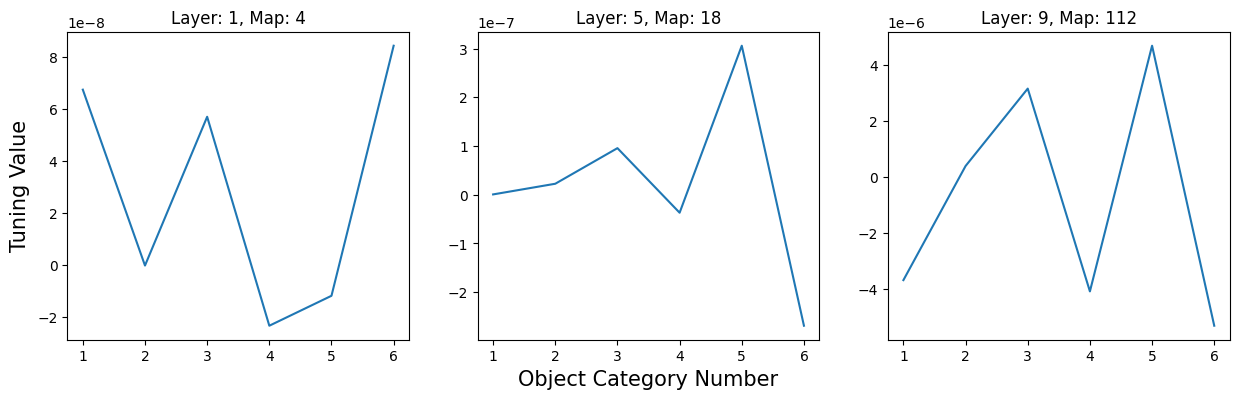

In [39]:
layers = [1,5,9]
maps = [4,18,112]
fig = pt.plot_tun_curves(cat_grads,layers,maps)

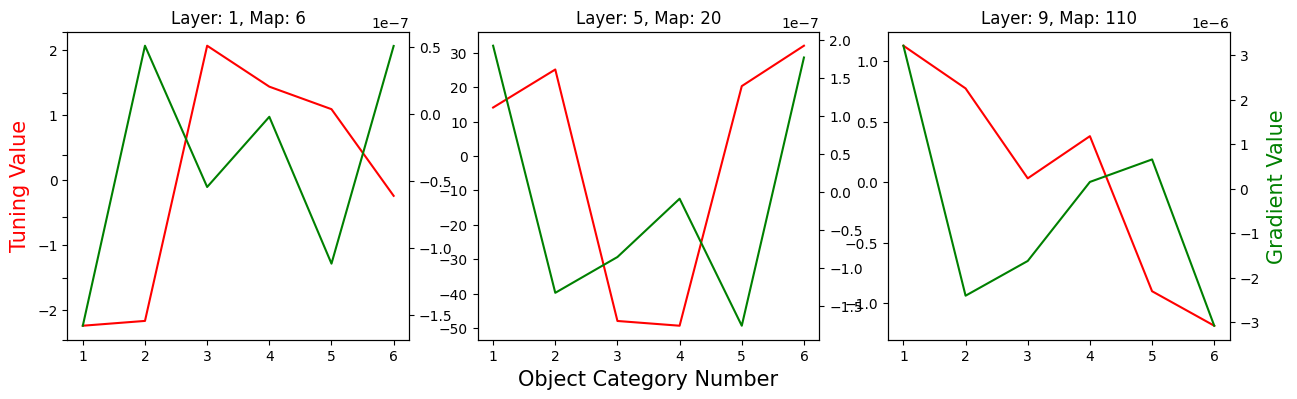

In [40]:
def plot_both_curves(data1,data2,layers,maps,figsize = (15,4)):
  if len(layers) != len(maps):
    raise ValueError('Sizes of layers and maps do not match')
  
  plot_data1 = np.zeros((len(data1),len(layers)))
  #Load data into plotting format
  for i in range(len(data1)):
    for iter in range(len(layers)):
      plot_data1[i,iter] = data1[i][layers[iter]][maps[iter]]

  plot_data2 = np.zeros((len(data1),len(layers)))
  #Load data into plotting format
  for i in range(len(data1)):
    for iter in range(len(layers)):
      plot_data2[i,iter] = data2[i][layers[iter]][maps[iter]]

  plt.style.use('default')
  fig = plt.figure(figsize = figsize)
  ax = fig.add_subplot(111)    # The big subplot

  # Turn off axis lines and ticks of the big subplot
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
  ax_2 = ax.twinx()
  ax_2.set_ylabel('Gradient Value',size = 15,color = 'green')
  ax_2.spines['top'].set_color('none')
  ax_2.spines['bottom'].set_color('none')
  ax_2.spines['left'].set_color('none')
  ax_2.spines['right'].set_color('none')
  ax_2.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

  for p in range(len(layers)):
    ax1 = fig.add_subplot(1,len(layers),p+1)
    ax1.plot(plot_data1[:,p],'r')
    ax1.set_title('Layer: ' + str(layers[p]) + ', Map: ' + str(maps[p]))
    ax1.set_xticklabels(np.arange(0,7))

    ax2 = ax1.twinx()
    ax2.plot(plot_data2[:,p],'g')
  ax.set_ylabel('Tuning Value',size = 15,color = 'red')
  ax.set_xlabel('Object Category Number',size = 15)
  
  return fig 

layers = [1,5,9]
maps = [6,20,110]
fig = plot_both_curves(fc,cat_grads,layers,maps)